# Analyse results from Pypsa-Earth

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Own setting

In [203]:
# Check config.yaml - run:
name = ""


# Check config.yaml - scenario: 
clusters = 10
opts = "Co2L-3H" 


## Import packages

In [257]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

## Path settings

In [205]:
nc_file_name = "elec_s_" + str(clusters) + "_ec_lcopt_" + opts + ".nc"
scenario_name = name 
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
results_path = "results/" + scenario_name + "/networks/" + nc_file_name
network_path = "networks/" + scenario_name + "/elec.nc"
# Country shape file
regions_onshore_path = "resources/" + scenario_name + "/shapes/country_shapes.geojson"
# Renewable profile file
solar_path = "resources/" + scenario_name + "/renewable_profiles/profile_solar.nc"
onwind_path = "resources/" + scenario_name + "/renewable_profiles/profile_onwind.nc" 

## Energy system analysis setup - power and energy generation

In [206]:
warnings.simplefilter(action='ignore', category=FutureWarning)
n = pypsa.Network(results_path)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Data import check

Country check

Text(0.5, 1.0, "['NA']")

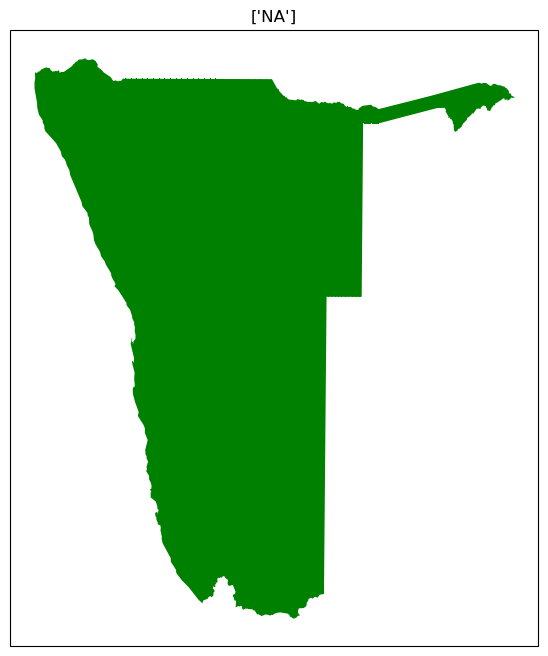

In [207]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

Component check

In [208]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 18 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 11 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 40 entries
Component 'StorageUnit' has 1 entries
Component 'Store' has 20 entries


Snapshot check

In [209]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 03:00:00',
               '2013-01-01 06:00:00', '2013-01-01 09:00:00',
               '2013-01-01 12:00:00', '2013-01-01 15:00:00',
               '2013-01-01 18:00:00', '2013-01-01 21:00:00',
               '2013-01-02 00:00:00', '2013-01-02 03:00:00',
               ...
               '2013-12-30 18:00:00', '2013-12-30 21:00:00',
               '2013-12-31 00:00:00', '2013-12-31 03:00:00',
               '2013-12-31 06:00:00', '2013-12-31 09:00:00',
               '2013-12-31 12:00:00', '2013-12-31 15:00:00',
               '2013-12-31 18:00:00', '2013-12-31 21:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2920, freq=None)
Time steps: 2920


## Analyse energy system

Analyse the current capacity of the energy system - map view

/home/aca39878/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


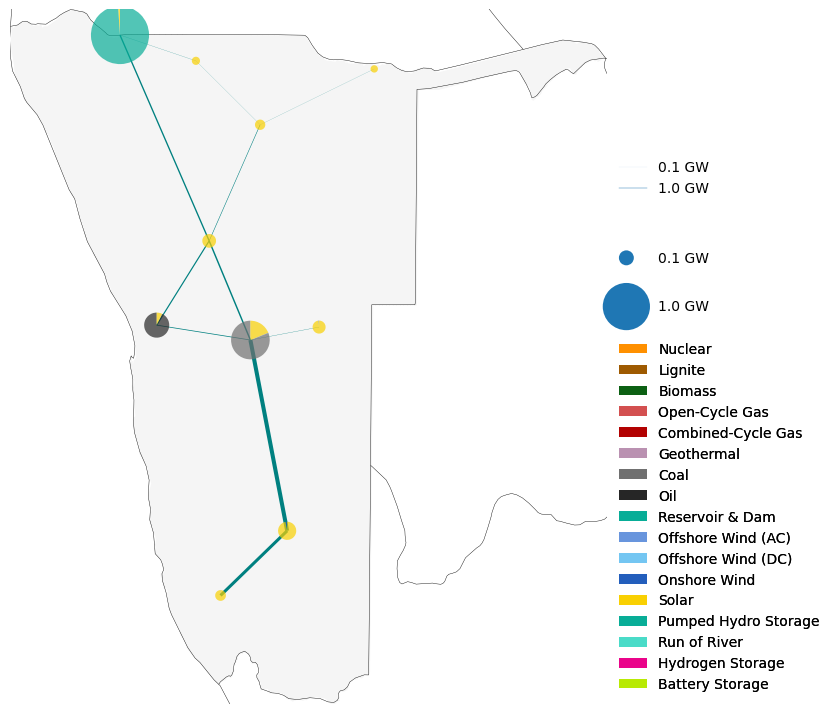

In [210]:
# Scale settings
bus_scale = 1e3 
line_scale = 3e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

Text(0.5, 1.0, 'Generator Capacity by Carrier')

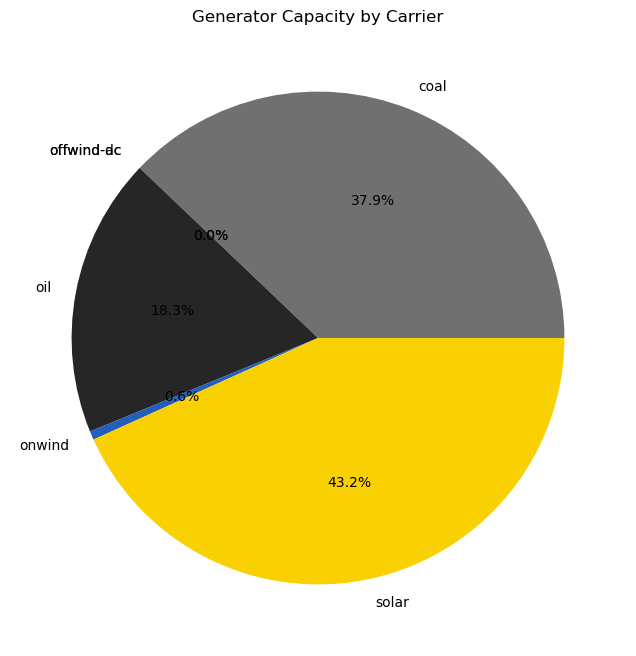

In [211]:
generator_capacity_by_carrier = n.generators[n.generators.carrier != "load"].groupby(["carrier"]).p_nom.sum()
plt.figure(figsize=(8, 8))
plt.pie(generator_capacity_by_carrier, labels=generator_capacity_by_carrier.index, autopct='%1.1f%%', colors=n.carriers[n.carriers.index.isin(generator_capacity_by_carrier.index)].color.reindex(generator_capacity_by_carrier.index))
plt.title("Generator Capacity by Carrier")

Analyse the current gernation capacity of the energy system - tabular view

In [212]:
generator_capacity_by_carrier/1e3 # in GW

carrier
coal          0.120000
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.058014
onwind        0.001807
solar         0.136971
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

/home/aca39878/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


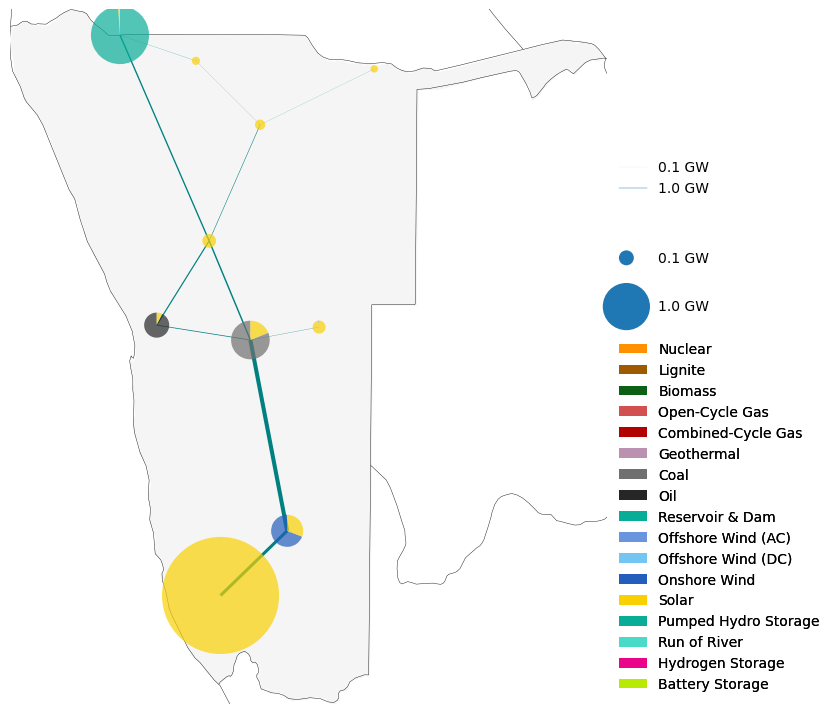

In [213]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<AxesSubplot:title={'center':'Generator capacity expansion in GW'}, xlabel='carrier'>

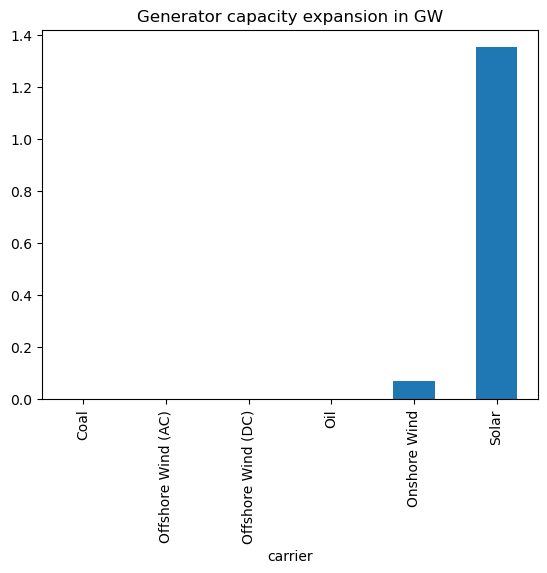

In [214]:
generation_capacity_expansion = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)-n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion.drop(["load"], inplace=True)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [215]:
generation_capacity_expansion # In GW

carrier
Coal                  0.000000
Offshore Wind (AC)    0.000009
Offshore Wind (DC)    0.000008
Oil                   0.000000
Onshore Wind          0.069650
Solar                 1.351646
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

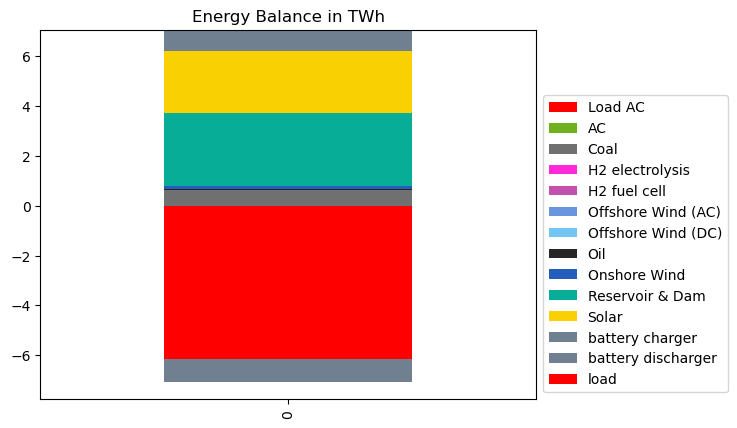

In [255]:
fig, ax = plt.subplots()
config = yaml.safe_load(open("config.yaml"))
colors = config["plotting"]["tech_colors"]
colors = {key.lower(): value.lower() for key, value in colors.items()}

energy_balance = n.statistics.energy_balance().loc[:, :, "AC"].groupby("carrier").sum().div(1e6).to_frame().T
energy_balance.rename(columns={'-': 'Load AC'}, inplace=True)

color_list = [colors.get(col.lower(), 'gray') for col in energy_balance.columns]

energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=color_list)

ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)
plt.show()

Analyse the future energy generation of the energy system - tabular view

In [253]:
n.statistics.energy_balance()/1e6 # In TWh

             carrier             bus_carrier
Line         AC                  AC             5.820766e-17
Link         H2 electrolysis     AC            -4.111219e-05
                                 H2             2.795629e-05
             H2 fuel cell        AC             1.397892e-05
                                 H2            -2.795783e-05
             battery charger     AC            -9.157154e-01
                                 battery        8.790868e-01
             battery discharger  AC             8.439233e-01
                                 battery       -8.790868e-01
Store        Battery Storage     battery       -6.093615e-17
             Hydrogen Storage    H2             8.326673e-23
Generator    Coal                AC             6.487464e-01
             Offshore Wind (AC)  AC             2.975175e-05
             Offshore Wind (DC)  AC             2.766083e-05
             Oil                 AC             2.829169e-02
             Onshore Wind        AC     

## Analyse pv and wind potential - map view

In [ ]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot wind energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


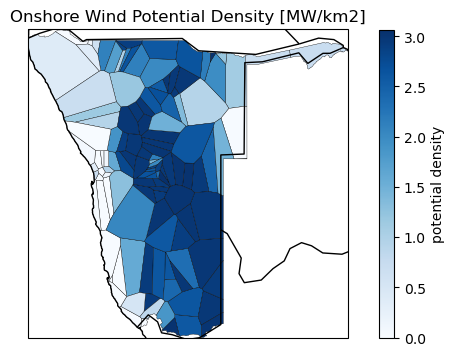

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot pv energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


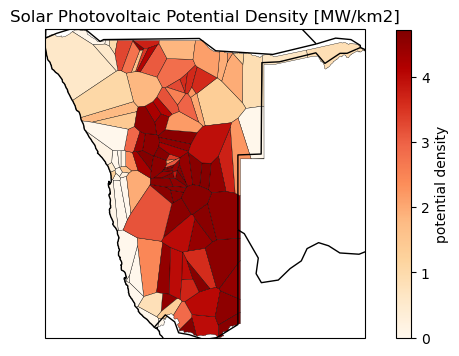

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)